In [57]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_root = "/root/music/compound-word-transformer/data"
path_eval = "/root/music/compound-word-transformer/data/eval"

metrics = [
    "total_used_pitch",  # PC
    "total_used_note",  # NC
    "total_pitch_class_histogram",  # PCH
    "pitch_class_transition_matrix",  # PCTM
    "pitch_range",  # PR
    "avg_pitch_shift",  # PI
    "avg_IOI",  # IOI
    "note_length_hist",  # NLH
    "note_length_transition_matrix",  # NLTM
]

metric_labels = ["PC", "NC", "PCH", "PCTM", "PR", "PI", "IOI", "NLH", "NLTM"]


def to_array(dict):
    return [dict[metric] for metric in metrics]

path_json = os.path.join(path_eval, "metrics.json")
content = json.load(open(path_json, "r"))

data = []
train_loss = []
valid_loss = []

for key in content.keys():
    data.append(to_array(content[key]["mean"]))
    data.append(to_array(content[key]["std"]))
    if key !="valid":
        data.append(to_array(content[key]["kldiv"]))
        data.append(to_array(content[key]["overlap"]))
        train_loss.append(content[key]["train_loss"])
        valid_loss.append(content[key]["valid_loss"])

data_stack = np.column_stack(data)

In [58]:
def expand(s: str, array: list):
    return [(s, *item) for item in array]

inner_1 = [("Mean",), ("STD",)]
inner_2 = [("KLD",), ("OA",)]
middle = expand("Intra-set", inner_1) + expand("Inter-set", inner_2)
outer = expand("Training data", expand("Intra-set", inner_1))
for i in range(20, 100+1, 20):
    for item in expand(f"Epoch {i}", middle):
        outer.append(item)

In [59]:
df = pd.DataFrame(
    data_stack,
    index=pd.Index(metric_labels),
    columns=pd.MultiIndex.from_tuples(outer)
)
pd.set_option("display.precision", 4)
df.style

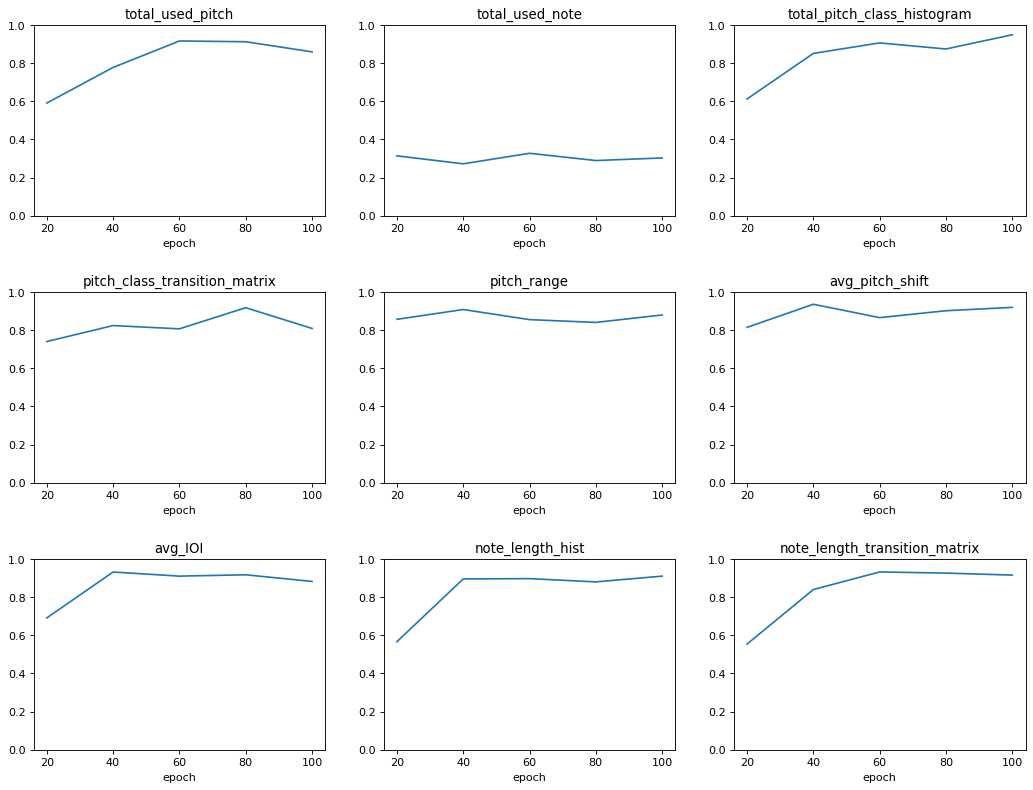

In [63]:
plt.figure(figsize=(16, 12), dpi=80)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i+1)
    
    x = [n for n in range(20, 100+1, 20)]
    y = [content[str(n)]["overlap"][metric] for n in x]
    plt.plot(x, y)
    plt.ylim([0, 1])
    plt.title(metric)
    plt.xlabel('epoch')
plt.show()

In [ ]:
df_loss = pd.DataFrame(
    [train_loss, valid_loss],
    index=pd.Index(["Train loss", "Valid loss"]),
    columns=pd.Index([f"Epoch {i}" for i in range(20, 100+1, 20)]),
)
df_loss.style

,Epoch 20,Epoch 40,Epoch 60,Epoch 80,Epoch 100
Train loss,0.7960,0.4460,0.3040,0.2150,0.1800
Valid loss,1.1999,1.3399,1.4284,1.5505,1.7642
